# Exercises 5 - Bayesian Update, Bayesian Classification
This exercise is composed of two main parts:

1. We will see how our **prior beliefs** for hypotheses are **updated** as we see more data by using the **Bayes' Rule**.
2. We will use **Naïve Bayes** classification and compare its performance to the similar Logistic Regression classifier.

## Bayesian Update

A manufacturer sells candies of two flavors: *cherry* and *lime*. All candies are wrapped with the same opaque wrapper, regardless of flavor. So, we cannot see the candy inside. The candies are sold in five types of large bags indistinguishable from the outside and have the following ratios of candies:

Bag 1: 100% cherry,  
Bag 2: 75% cherry + 25% lime,  
Bag 3: 50% cherry + 50% lime,   
Bag 4: 25% cherry + 75% lime,  
Bag 5: 100% lime.

Note: The example in Task 1 is adapted from the book *Artificial Intelligence: A Modern Approach by S.Russell, P.Norvig* (see p802 in 3rd Edition).

## Task 1
The manufacturer says that the bags are distributed with the (0.1, 0.2, 0.4, 0.2, 0.1) ratios, respectively (i.e., Bag 3 is the most common). We are given a bag and not told which type. We draw 10 candies and find out that all of them are of flavour *lime*. 

Our task is, for each bag, finding the probability that these candies are drawn from that bag. That is, we are looking for:

$$ 
P(h_{i} | data) = \frac{P(data|h_{i}) P(h_{i})}{P(data)} = 
\frac{P(data|h_{i}) P(h_{i})}{\sum_{i}P(data|h_{i}) P(h_{i})}, \forall i \in [1..5]
$$

where, $h_{i}$ is the hypothesis that the candies are drawn from Bag $i$ and $data=lime\,\times\,10$.

In [1]:
import math
from typing import List

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

/var/folders/gn/r458706x33q7fvtnfw1dl9dm0000gp/T/ipykernel_36317/1952765212.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


We start with creating a class for Bayesian Update. Make sure you understand the class code although you will not be asked to modify it.

In [2]:
class BayesTableForCandies():
    """A class for the 'Bayesian Update' of the hypotheses for a candy experiment.
    
    Here, the hypothesis_i is that the candies are drawn from Bag i.
    """
    
    def __init__(self, n_bags: int, likelihood_lime: List[float], prior: List[float]):
        """Create 
            1. A pandas.Dataframe for the Bayesian update of hypotheses;
            2. A pandas.Series to track history of posteriors of hypotheses.

        n_bags: Number of bags
        likelihood_lime: List of probabilities of drawing a lime candy from each bag
        prior: The probability of choosing each bag (This probability can be assumed or given to us a priori)
        """
        assert n_bags==len(likelihood_lime)==len(prior)  # Argument validation
        assert np.sum(prior, dtype=np.float32)==1.  # Priors should sum up to 1
        # Create the Bayes table
        self.table = pd.DataFrame(index=[f"Bag {i}" for i in range(1, n_bags + 1)])
        self.table["likelihood_lime"] = likelihood_lime
        self.table["likelihood_cherry"] = 1. - self.table["likelihood_lime"]
        self.table["prior"] = prior
        self.table["posterior"] = [.0] * n_bags
        # Initialize the posterior history for each bag. Initial `prior` is the first record.
        self.posterior_history = self.table["prior"].apply(lambda x: [x]).rename("posteriors")
    
    
    def bayesian_update(self, candy: str) -> np.ndarray:
        """Get a candy and update the posteriors for the hypotheses with the Bayes' Rule."""
        assert candy in ["L", "C"]  # Check a valid candy is given. L: lime, C: cherry.
        if self.table["posterior"].any():  # If this is not the first update
            self.table["prior"] = self.table["posterior"]  # last posterior -> new prior
        likelihood = self.table["likelihood_lime"] if candy == "L" else self.table["likelihood_cherry"]
        self.table["posterior"] = likelihood * self.table["prior"]
        self.table["posterior"] = self.table["posterior"] / self.table["posterior"].sum()  # normalize the posterior to [0., 1.]
        # Append the new posteriors to the corresponding bag's history
        for ix, posterior in self.table["posterior"].items():
            self.posterior_history.loc[ix].append(posterior)
        
        return self.table["posterior"].to_numpy()  # updated posteriors



In [3]:
# Create the Bayes Table for Task 1.
btable = BayesTableForCandies(n_bags=5, likelihood_lime=[0, .25, .50, .75, 1.], prior=[.1, .2, .4, .2, .1])
btable.table

,likelihood_lime,likelihood_cherry,prior,posterior
Bag 1,0.00,1.00,0.1,0.0
Bag 2,0.25,0.75,0.2,0.0
Bag 3,0.50,0.50,0.4,0.0
Bag 4,0.75,0.25,0.2,0.0
Bag 5,1.00,0.00,0.1,0.0


> Note that neither of the *likelihood* columns adds up to one. Each likelihood is the probability of the $data$ conditioned on a different hypothesis $h_i$. There is no reason for them to add up to one. That's why we call $P(data|h_{i})$ the *likelihood of $h_i$* and _**not** the probability_ of it.

Then, we make Bayesian Updates of our beliefs for the observed 10 *lime* candies.

In [4]:
data_observations = "L" * 10
for candy in data_observations:
    new_posteriors = btable.bayesian_update(candy)

The answer, that is, the posterior probability of each bag after observing 10 *lime* candies are:

In [5]:
new_posteriors

array([0.00000000e+00, 1.70827454e-06, 3.49854626e-03, 1.00871903e-01,
       8.95627842e-01])

After these observations, we have reason to believe that we are given Bag 5 as it has the highest posterior probability. Note that we can be (100%) certain that we are not holding Bag 1 as it has 0 posterior probability. 

Now, let's plot the posteriors for each update and see how our beliefs for the hypotheses changed after each update. 
> Just have an idea what the function does, you will use it as-is but you will not be asked to modify it.

In [6]:
import itertools
from collections import Counter

In [7]:
def plot_posterior_history(history: pd.Series, data: str, markers=(',', '+', '.', '*', 's')):
    """Plots the posterior history of each of the hypotheses."""
    plt.figure().gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    marker = itertools.cycle(markers)
    n_observations = len(data)
    n_each_candy = Counter(data)
    for ix, posteriors in history.items():
        plt.plot(np.arange(n_observations + 1), posteriors, label=ix, marker=next(marker))
    plt.xlim([0, n_observations])
    plt.ylim([0., 1.])
    plt.title(f"Observations: {dict(n_each_candy)}")
    plt.xlabel("Number of candy observations")
    plt.ylabel("Posterior probability of hypothesis")
    plt.legend()
    plt.show()
    plt.close()

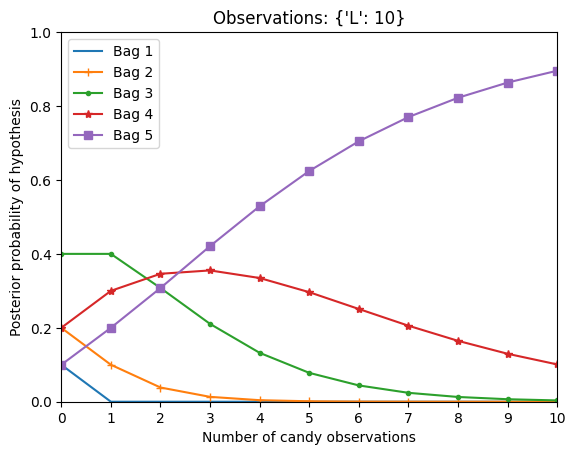

In [8]:
plot_posterior_history(btable.posterior_history, data_observations)

We see in the above figure that the hypotheses start with their initial priors. As we observe data, our (posterior) beliefs about the hypotheses change. After three *lime* candies, Bag 5 becomes the most likely hypothesis. And continued observation of the same flavor makes the posterior probability of Bag 5 gradually converge to `1.0`. In other words, after each consecutive *lime* candy pick, we start to believe more that we are holding the Bag 5 that has 100% *lime*.

<font color=blue>We draw a new candy (i.e., the eleventh) and find out this time that it is a *cherry*. What would be the posterior probability for Bag 5 now?</font>

---

*It would be 0, because we know that Bag 5 does not contain cherry candies.*

---

<font color=blue>We continue to draw nine more candies and, to our surprise, all are *cherries*! Which bag would have the highest posterior now? Which bag(s) would have posterior(s) that is(are) exactly 0.0?</font>

---

*Bag 3 would have the highest posterior probability because we have observed equal number of lime and cherry flavoured candies. *Bag 3 would have the highest posterior probability because we have observed equal number of lime and cherry flavoured candies. Bag 1 and Bag 5 would have zero posteriors since we observed both type of candies and we know that each of these two bags can contain only one type.*

---


## Task 2

We will conduct two experiments in parallel, again with 5 bags. In the first experiment, the *lime* likelihoods and bags' prior probabilties are the same as in [Task 1](#Task-1). In the second experiment, the *lime* likelihoods are also the same, but we are not provided with the bags' prior probabilities. Therefore, we assume that the bags are distributed with *uniform prior* probability (i.e., each bag has the same prior probability).

<font color=blue>Create two new Bayes tables --`btable1` and `btable2`-- for these two experiments, respectively.</font>

In [9]:
btable1 = BayesTableForCandies(n_bags=5, likelihood_lime=[0, .25, .50, .75, 1.], prior=[.1, .2, .4, .2, .1])
btable2 = BayesTableForCandies(n_bags=5, likelihood_lime=[0, .25, .50, .75, 1.], prior=[.2, .2, .2, .2, .2])

We observe 5 lime and 20 cherry candies in both experiments.

<font color=blue>Carry out Bayesian update with `btable1` and `btable2` for these observations and print the posterior probabilities for both tables.</font>

In [10]:
data_observations2 = "L" * 5 + "C" * 20
for candy in data_observations2:
    new_posteriors1 = btable1.bayesian_update(candy)
    new_posteriors2 = btable2.bayesian_update(candy)

<font color=blue>Plot the posterior histories for both experiments.</font>

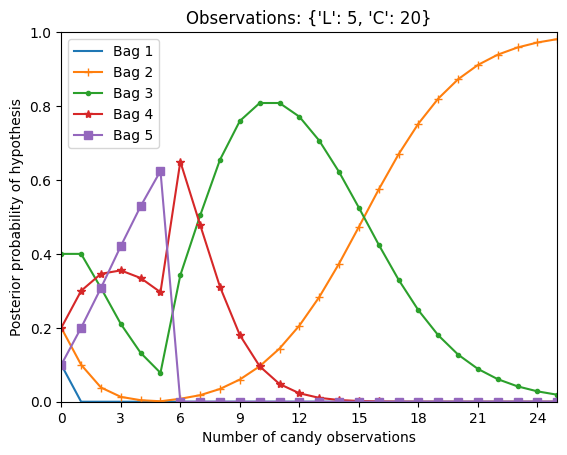

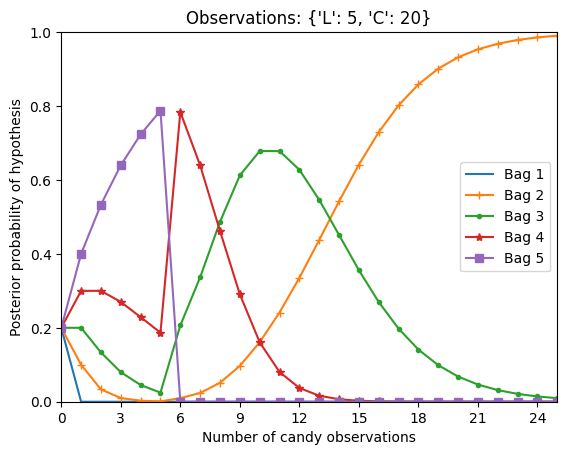

In [11]:
plot_posterior_history(btable1.posterior_history, data_observations2)
plot_posterior_history(btable2.posterior_history, data_observations2)

<font color=blue>After having many observations, do you think our prior beliefs matter much for the posteriors? Explain why.</font>

---

*Not really. With enough data, different priors on hypotheses will converge to the same posterior probability distribution. That is, (reasonable) people with different prior beliefs of hyphotheses would end up agreeing on the same hypothesis after observing enough data.*

---

# Naïve Bayes classification

## Import data
We will work with the [Iris dataset](https://en.wikipedia.org/wiki/Iris_flower_data_set) that we saw previously.

In [12]:
from sklearn.datasets import load_iris

iris = load_iris(as_frame=True)

Let's explore the data before classification tests.

In [13]:
# Features have continuous values (float)
iris.data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
dtypes: float64(4)
memory usage: 4.8 KB


In [14]:
# Classes are discrete values
iris.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

Let's choose two features to work with, for now.

In [15]:
feat1 , feat2 = iris.feature_names[2:4]  # 'petal length (cm)', 'petal width (cm)'

In [16]:
X = iris.data[[feat1 , feat2]]
y = iris.target

In [17]:
# Import multivariate Gaussian distribution to model continuous-valued features for exploration
from scipy.stats import multivariate_normal

Now, we define the functions to be used in plotting henceforth. 
> Just have an idea what the functions do, you will not be asked to modify the plotting code.

In [18]:
# Set the color map for plots
cmap = plt.cm.tab10

In [19]:
def plt_limit(plt: plt, X: pd.DataFrame):
    """Set plot's margins"""
    plt.xlim([math.floor(X.iloc[:, 0].min()), math.ceil(X.iloc[:, 0].max())])
    plt.ylim([math.floor(X.iloc[:, 1].min()), math.ceil(X.iloc[:, 1].max())])

In [20]:
def quantize(X_i: pd.Series, sigmas: int=3, n: int=101) -> np.ndarray:
    """Quantize a pandas Series w.r.t. to its mean and standard deviation.
    
    X_i: i^th input feature
    sigmas: Number of std deviation
    n: Number of intervals
    """
    mean, std = X_i.mean(), X_i.std()
    low = mean - sigmas * std
    up = mean + sigmas * std
    samples = np.linspace(low, up, n)
    
    return samples

In [21]:
def plot_contour2D(X: pd.DataFrame, y: pd.Series, y_names: List[str], nb: bool=False, **options):
    """Plot contour lines of the bivariate distribution of the two features for each class.
    
    X: Input data with two features
    y: Input target
    y_names: Target class names
    nb: If True, the bivariate distribution is estimated w.r.t. Naïve Bayes' assumption
    options: Passed to the `matlplotlib.pyplot.contour` function
    """
    assert X.shape[1] == 2
    assert X.shape[0] == y.shape[0]
    df = pd.concat([X, y], axis=1)
    grouped = df.groupby(df.columns[-1])  # Group input data by target, i.e., the last column   
    for target, group in grouped:
        X1, X2 = group.iloc[:, 0], group.iloc[:, 1]
        plt.scatter(X1, X2, c=cmap(np.full(X1.size, target)), label=y_names[target])  # Plot the data points
        mean = group.iloc[:, 0:2].mean()  # X1 and X2
        cov = group.iloc[:, 0:2].cov()
        if nb:
            cov.iloc[0, 1] = cov.iloc[1, 0] = 0. 
        multinorm = multivariate_normal(mean, cov)
        X1_q, X2_q = quantize(X1), quantize(X2)
        X1, X2 = np.meshgrid(X1_q, X2_q)
        pos = np.dstack((X1, X2))
        plt.contour(X1, X2, multinorm.pdf(pos), linewidths=1, **options)  # Plot the contours for the `target` class
    plt.xlabel(X.columns[0])
    plt.ylabel(X.columns[1])
    plt.title("Density Contours " + ("w.r.t. Naïve Bayes" if nb else "w/ covariance of the features"))
    plt_limit(plt, X)
    plt.legend()
    plt.show()
    plt.close()

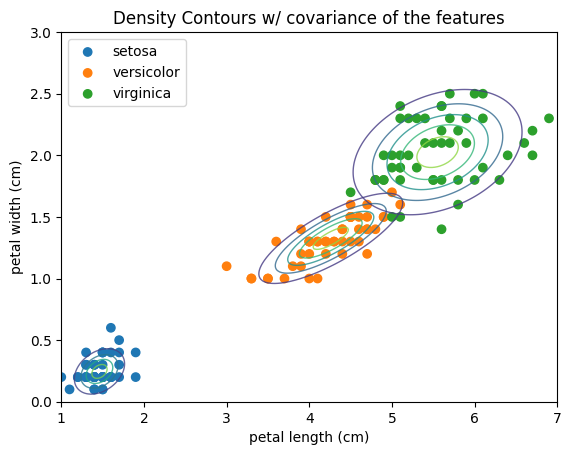

In [22]:
# Plot bivariate Gussian densities for the select features
plot_contour2D(X, y, iris.target_names, alpha=0.8, levels=5)

<font color=blue>Interpret the diagonally stretched density contour lines for these two features.</font>

---

*Petal length and width features are correlated. Moreover, this is true for each class.*

---

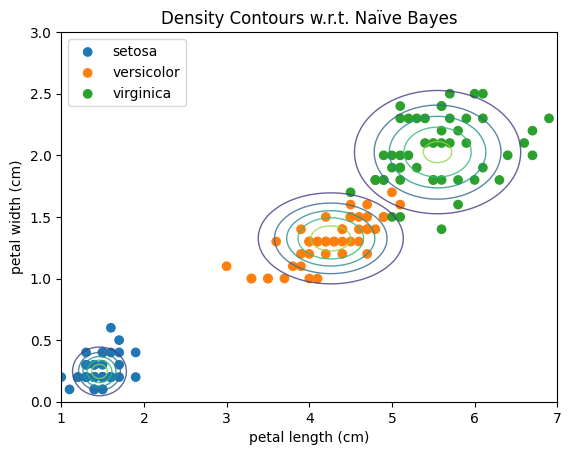

In [23]:
# Plot densities for the features w.r.t. Naïve Bayes' assumption
plot_contour2D(X, y, iris.target_names, nb=True, alpha=0.8, levels=5)

<font color=blue>Why are the axes of the density contour lines parallel to the features' axes in the case of Naïve Bayes? i.e., Why did we add the hard-coded line in the `plot_contour` function for NB?</font>

---

*Naïve Bayes assumes that the features are **conditionally independent given the class**, so, their covariances are zero given the class. Formally, $X_{1} \perp X_{2}\,|\,y_{k} \Rightarrow Cov(X_{1}, X_{2}\,|\,y_{k}) = 0$. Therefore, we manually reset their covariances and so, the contour-axes seem parallel to the feature axes. (_see_ bivariate distribution examples in the lecture slides).*

---

## Classification

In [24]:
from sklearn.naive_bayes import GaussianNB
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score 

We define a function to visualize the decision boundaries for a two-feature dataset.
> Just have an idea what the function does, you will not be asked to modify the code.

In [25]:
def plot_decision_boundaries2D(classifier: object, X_train, X_test, y_train, y_test):
    """Plots the decision boundaries and training and test data points."""
    X = pd.concat([X_train, X_test], axis=0)
    disp = DecisionBoundaryDisplay.from_estimator(
        classifier, X, 
        response_method="predict",
        xlabel=X.columns[0], ylabel=X.columns[1],
        cmap=cmap,
        alpha=0.1,
        grid_resolution=200)
    # Plot Training data points
    disp.ax_.scatter(X_train.iloc[:, 0], X_train.iloc[:, 1], c=cmap(y_train), alpha=0.2, 
                     marker="o", label="Training")
    # Plot Test data points
    miss = y_test != classifier.predict(X_test)
    disp.ax_.scatter(X_test[~miss].iloc[:, 0], X_test[~miss].iloc[:, 1], c=cmap(y_test[~miss]), edgecolor="k", 
                     marker="o", label="Test correctly classified")
    disp.ax_.scatter(X_test[miss].iloc[:, 0], X_test[miss].iloc[:, 1], c=cmap(y_test[miss]), edgecolor="r", 
                     marker="D", label="Test misclassified")
    plt_limit(plt, X)
    plt.suptitle(f"Decision boundaries of the {classifier.__class__.__name__} classifier")
    plt.title("with Training and Test data points")
    plt.legend()

We create Training and Test datasets.

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

First, let's use Logistic Regression's performance on this dataset. (Actually, this is known as the *Multinomial* Logistic Regression as there are more than two classes.)

In [27]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(max_iter=400)
# Fit the model and predict the test data
y_pred_log_reg = log_reg.fit(X_train, y_train).predict(X_test)

In [28]:
accuracy_score(y_test, y_pred_log_reg)

0.9736842105263158

Not bad. Let's see the decision boundaries learned by this classifier.

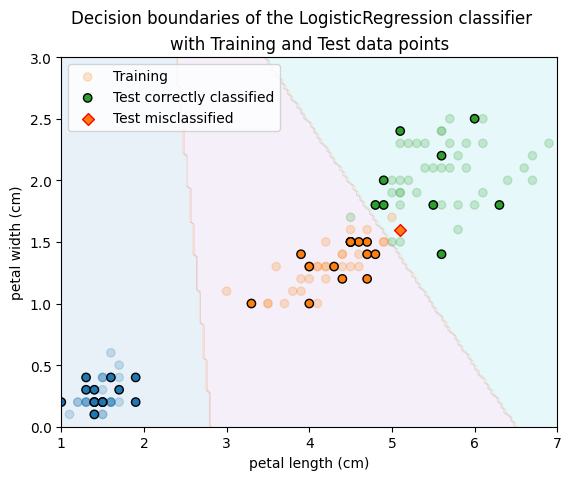

In [29]:
plot_decision_boundaries2D(log_reg, X_train, X_test, y_train, y_test)

Note the linear boundaries of Logistic Regression and one mislabeled test instance.

<font color=blue>Use the same `train` and `test` datasets to fit a Gaussian Naïve Bayes classifier (`GaussianNB`) and make predictions, respectively.</font>

In [30]:
gnb = GaussianNB()
y_pred_gnb = gnb.fit(X_train, y_train).predict(X_test)

<font color=blue>What is the accuracy score for the Gaussian Naïve Bayes?</font>

In [31]:
accuracy_score(y_test, y_pred_gnb)

0.9736842105263158

<font color=blue>Plot the decision boundaries of this Gaussian Naïve Bayes classifier like we did for the Logistic Regression above.</font>

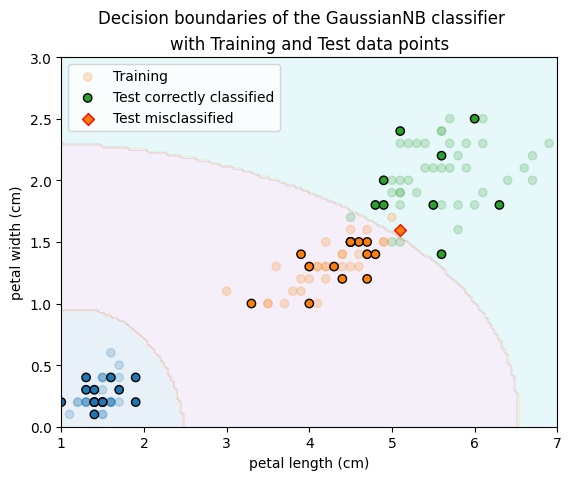

In [32]:
plot_decision_boundaries2D(gnb, X_train, X_test, y_train, y_test)

<font color=blue>Are the decision boundaries different for both classifiers? Why or why not?</font>

---

*Yes, they are different although they would end up with similar discriminations for this dataset. In general, different classifier models learn different decision boundaries (or decision surfaces for that matter).*

---

Now, let's compare the performances of the two classifiers on the whole datset (all features) with cross validation:

In [33]:
X = iris.data

In [34]:
from sklearn.model_selection import ShuffleSplit, cross_val_score

gnb2 = GaussianNB()
log_reg2 = LogisticRegression(max_iter=400)

cv = ShuffleSplit(n_splits=10, test_size=0.25, random_state=0)
scores_gnb = cross_val_score(gnb2, X, y, cv=cv)
scores_log_reg = cross_val_score(log_reg2, X, y, cv=cv)
print("Cross validation (accuracy) scores:")
print("    Gaussian NB -> mean:", scores_gnb.mean(), "std:", scores_gnb.std())
print("    Logistic Regression -> mean:", scores_log_reg.mean(), "std:", scores_log_reg.std())

Cross validation (accuracy) scores:
    Gaussian NB -> mean: 0.9552631578947368 std: 0.03912123354557502
    Logistic Regression -> mean: 0.9657894736842104 std: 0.028947368421052652


<font color=blue>It is known that when the Gaussian NB modeling assumption holds, Logistic Regression and Gaussian NB converge toward identical classifiers\*. Interpret why Gaussian NB slightly underperformed Log Reg for this dataset.</font><small>\* _see_ the reference for T. Mitchell in the Lecture 5's Resources slides.</small>

---

*We just saw above that, at least, petal length and width features are correlated. This violates the Naïve Bayes assumption. That said, the performance of the Gaussian Naive Bayes is very close to the Logistic Regression's. i.e., It works well anyways!*

---